In [1]:
import numpy as np
#import time
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import os,argparse
import pytesseract
from PIL import Image

In [2]:
INPUT_FILE='pan.jpg'
OUTPUT_FILE='predicted.jpg'
LABELS_FILE='data/obj.names'
CONFIG_FILE='cfg/yolov4-obj.cfg'
WEIGHTS_FILE='Yolo_weignts_pan.weights'
CONFIDENCE_THRESHOLD=0.3

In [3]:
LABELS = open(LABELS_FILE).read().strip().split("\n")
LABELS

['Name', 'Fathers_name', 'DOB', 'Pan_number']

In [4]:
#np.random.seed(4)
#COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")
#COLORS

In [5]:
net = cv2.dnn.readNetFromDarknet(CONFIG_FILE, WEIGHTS_FILE)
net

<dnn_Net 0x7f7c92fe7090>

In [6]:
image = cv2.imread(INPUT_FILE)
(H, W) = image.shape[:2]

In [7]:
# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [8]:
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
layerOutputs = net.forward(ln)
end = time.time()
print("[INFO] YOLO took {:.6f} seconds".format(end - start))


[INFO] YOLO took 0.642514 seconds


In [28]:
boxes = []
confidences = []
classIDs = []

# loop over each of the layer outputs
for output in layerOutputs:
    # loop over each of the detections
    for detection in output:
        # extract the class ID and confidence (i.e., probability) of
        # the current object detection
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]

        # filter out weak predictions by ensuring the detected
        # probability is greater than the minimum probability
        if confidence > CONFIDENCE_THRESHOLD:
            # scale the bounding box coordinates back relative to the
            # size of the image, keeping in mind that YOLO actually
            # returns the center (x, y)-coordinates of the bounding
            # box followed by the boxes' width and height
            box = detection[0:4] * np.array([W, H, W, H])
            (centerX, centerY, width, height) = box.astype("int")

            # use the center (x, y)-coordinates to derive the top and
            # and left corner of the bounding box
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))

            # update our list of bounding box coordinates, confidences,
            # and class IDs
            boxes.append([x, y, int(width), int(height)])
            confidences.append(float(confidence))
            classIDs.append(classID)
#boxes

In [10]:
classIDs[12]

1

In [12]:
# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
idxs = cv2.dnn.NMSBoxes(boxes, confidences, CONFIDENCE_THRESHOLD,CONFIDENCE_THRESHOLD)
idxs

array([[ 9],
       [ 6],
       [ 0],
       [12]], dtype=int32)

In [14]:
for i in idxs.flatten():
    print(i)

9
6
0
12


In [15]:
coord_df = pd.DataFrame()
master = {}
coord = []
# ensure at least one detection exists
if len(idxs) > 0:
    # loop over the indexes we are keeping
    a = 0
    for i in idxs.flatten():
        # extract the bounding box coordinates
        #(x, y , w, h) = (boxes[i][0], boxes[i][1], boxes[i][2], boxes[i][3])
        #(w, h) = (boxes[i][2], boxes[i][3])
        coord = []
        #print(class_IDs[i])
        x = boxes[i][0]
        y = boxes[i][1]
        w = boxes[i][2]
        h = boxes[i][3]
        #res = x+y+w+h
        coord.append(x)
        coord.append(y)
        coord.append(w)
        coord.append(h)
        
        if classIDs[i] == 0:
            master['Name'] = coord
        elif classIDs[i] == 1:
            master['Fathers_name'] = coord
        elif classIDs[i] == 2:
            master['DOB'] = coord
        elif classIDs[i] == 3:
            master['Pan_number'] = coord
        #print(coord)
        #print(a)
master
        #coord_df.append(a)
        #master = dict({a: coord})
        #master
#coord_df

{'Pan_number': [101, 230, 107, 24],
 'DOB': [96, 182, 92, 28],
 'Name': [92, 110, 177, 22],
 'Fathers_name': [90, 145, 145, 24]}

<class 'numpy.ndarray'>


True

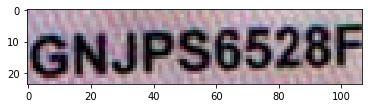

In [16]:
crop = image[230:254, 101:208]
print(type(crop))
plt.imshow(crop)
cv2.imwrite('Pan_Number.jpg', crop)

In [17]:
text = pytesseract.image_to_string(Image.open('Pan_Number.jpg'))
print((text))

GNJPS6528F



In [18]:
df = pd.DataFrame(master)
df = df.T
df.columns =['x', 'y', 'w', 'h']
df

,x,y,w,h
Pan_number,101,230,107,24
DOB,96,182,92,28
Name,92,110,177,22
Fathers_name,90,145,145,24


In [19]:
df.iloc[:,1] 

Pan_number      230
DOB             182
Name            110
Fathers_name    145
Name: y, dtype: int64

In [20]:
df['y1'] = df.iloc[:,1] + df.iloc[:,3]
df['x1'] = df.iloc[:,0] + df.iloc[:,2]

In [21]:
df

,x,y,w,h,y1,x1
Pan_number,101,230,107,24,254,208
DOB,96,182,92,28,210,188
Name,92,110,177,22,132,269
Fathers_name,90,145,145,24,169,235


In [22]:
df.iloc[0,1]

230

In [27]:
text_dict = {}

for i in range(df.shape[0]):
    crop = image[df.iloc[i,1]:df.iloc[i,4], df.iloc[i,0]:df.iloc[i,5]]
    #print(type(crop))
    #plt.imshow(crop)
    name = list(df.index)[i] + ".jpg"
    cv2.imwrite(name, crop)
    text = pytesseract.image_to_string(Image.open(name))
    #print(text.strip())
    text_dict[list(df.index)[i]] = text.strip()
text_dict

{'Pan_number': 'GNJPS6528F',
 'DOB': '05/07/1996',
 'Name': 'JAY PRAKASH SHARM/',
 'Fathers_name': 'PRAMOD SHARMA'}